In [1]:
import numpy as np
import torch
import pandas as pd
import os
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
# set the working directory to the root of RCANE project
os.chdir('/Volumes/gech/cna/RCANE')
from model.model_architecture import RCANE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Load the RNA and CNA data

In [2]:
rna = np.load('data/predict/TCGA_test.npz')['rna']
cna = np.load('data/predict/TCGA_test.npz')['cna']

Load the trained model and gene names in each chromosome segment

In [10]:
model = torch.load('model/trained_model/RCANE_mp0.25_20241017_153141_cuda.pth',map_location=torch.device(device))
gene_names_in_segs = np.loadtxt('data/gene_names_in_segments.csv', delimiter=',', dtype=str)

Get the weights of each gene

In [11]:
# get the weights of each gene
w = model.weights.detach().numpy()
# delete segments with gene names 'None'
none_index = np.unique(np.where(gene_names_in_segs == 'None')[0])
w_nonone = np.delete(np.copy(w), none_index, axis=0)
# convert the weights to probability using softmax
w_s_nonone = scipy.special.softmax(w_nonone, axis=1)

Compute the Pearson's r and aneuploidy ratio

In [12]:
low_thre = -0.25
high_thre = 0.2
weight_list = []
pearson_r_list = []
gene_name_list = []
rna_nonone = rna.copy()
rna_nonone = np.delete(rna_nonone, none_index, axis=1)
cna_nonone = cna.copy()
cna_nonone = np.delete(cna_nonone, none_index, axis=1)
gene_names_nonone = np.delete(gene_names_in_segs,none_index,axis=0)
cna_status = -1*np.isnan(cna_nonone) + 0*(cna_nonone < low_thre) + 1*(cna_nonone >=low_thre)*(cna_nonone <= high_thre) + 2*(cna_nonone > high_thre)
aneuploidy_ratio_list = []
for i in range(cna_nonone.shape[1]):
    for j in range(20):
        cna_data = cna_nonone[:,i].reshape(-1)
        rna_data = rna_nonone[:,i,j].reshape(-1)
        nonone_mask = ~np.isnan(cna_data) & ~np.isnan(rna_data)
        cna_data_nonone = cna_data[nonone_mask]
        rna_data_nonone = rna_data[nonone_mask]
        if len(cna_data_nonone) < 2:
            continue
        weight_list.append(w_s_nonone[:,:-1,0][i,j])
        pearson_r_list.append(pearsonr(cna_data_nonone, rna_data_nonone)[0])
        gene_name_list.append(gene_names_nonone[i,j])
        aneuploidy_ratio_list.append(np.sum(cna_status[:,i] != 1)/len(cna_status[:,i]))
pearson_r = np.array(pearson_r_list)
weight = np.array(weight_list)
gene_name = np.array(gene_name_list)
aneuploidy_ratio = np.array(aneuploidy_ratio_list)

Plot the Pearson correlation of RNA and CNA v.s. model weight

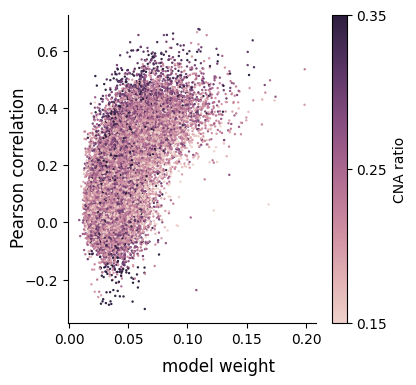

In [13]:
fig, ax = plt.subplots(figsize=(4,4))
random_index = np.random.choice(range(len(weight)),len(weight),replace=False)
plt.scatter(weight[random_index],pearson_r[random_index], c=aneuploidy_ratio[random_index], s=.5, cmap=sns.cubehelix_palette(as_cmap=True),vmin=0.15,vmax=0.35,rasterized=True)
plt.colorbar(label='CNA ratio',ticks=[0.15,0.25,0.35])
fig.supxlabel('model weight',y=-0.02)
fig.supylabel('Pearson correlation',x=-0.02)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

Plot the weight of genes (and cancer types) for given segment index

Text(0.5, 1.0, 'Chr3 184174689-185052614')

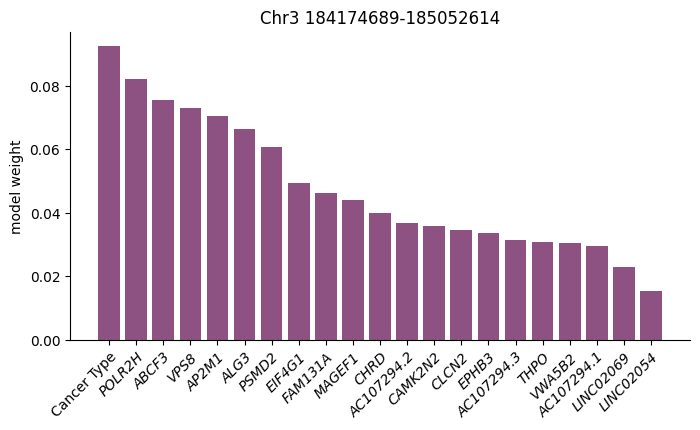

In [14]:
index_seg = 325
chr_start_end = pd.read_csv('data/start_end_chr_in_segs.csv')
w_sm = scipy.special.softmax(w[index_seg]).reshape(-1)
gene_names_sm = np.array(list(gene_names_in_segs[index_seg,:]) + ['Cancer Type'])
fig, ax = plt.subplots(figsize=(8,4))
index = np.argsort(-w_sm)
ax.bar(gene_names_sm[index], w_sm[index],color='#8d5282')
lab = gene_names_sm[index]
ax.set_xticks(range(len(lab)))
ax.set_xticklabels(lab, rotation=45, ha='right', rotation_mode='anchor')
for _, label in enumerate(ax.get_xticklabels()):
    if label.get_text() != 'Cancer Type':
        label.set_fontstyle('italic')  # Italicize labels for genes
    else:
        label.set_fontstyle('normal') 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('model weight')
ax.set_title(f'Chr{chr_start_end["chrom"][index_seg]} {chr_start_end["loc.start"][index_seg]}-{chr_start_end["loc.end"][index_seg]}')

Text(0.08, 0.5, 'CN Intensity (log2 ratio)')

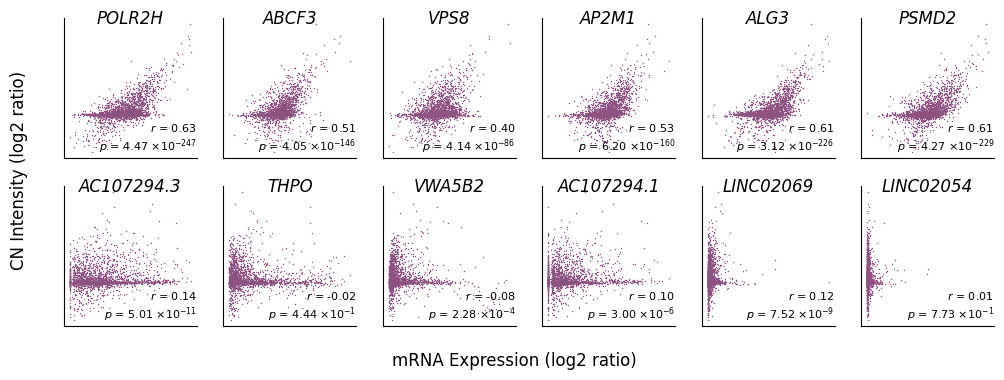

In [15]:
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} $\times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str
loc = [(0.05,.65),(1,0.02)]
mas = ['left','right']
has = ['left','right']
weight_arg = np.argsort(-weight)[:8]
fig, ax = plt.subplots(2,6,figsize=(12,4))
gene_to_plot = [i for i in gene_names_sm[index] if i!= 'Cancer Type']
for i in range(2):
    for j in range(6):
        if i==0:
            gene = gene_to_plot[j]
        else:
            gene = gene_to_plot[14+j]
        cna_data = cna_nonone[:,np.where(gene_names_nonone==gene)[0]].reshape(-1)
        rna_data = rna_nonone[:,np.where(gene_names_nonone==gene)[0],np.where(gene_names_nonone==gene)[1]].reshape(-1)
        sns.scatterplot(x=rna_data,y=cna_data, ax=ax[i,j], s=1,c='#8d5282',linewidth=0,rasterized=True)
        ax[i,j].set_title(gene,y=.9,style='italic')
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        r, p = pearsonr(cna_data, rna_data)
        if p==0:
            ax[i,j].annotate(f'$r$ = {r:.2f}\n'+r'$p\approx$0', fontsize=8, xy = (1,0.02), xycoords='axes fraction', ha='right', va='bottom',multialignment='right')
        else:
            ax[i,j].annotate(f'$r$ = {r:.2f}\n'+r'$p$ = '+latex_float(p), fontsize=8, xy = (1,0.02), xycoords='axes fraction', ha='right', va='bottom',multialignment='right')
fig.supxlabel('mRNA Expression (log2 ratio)', ha='center',y=0)
fig.supylabel('CN Intensity (log2 ratio)', va='center',x=0.08)
